In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
import multiprocessing as mp

In [2]:
import sys
module_path = '/Users/junhaoxiong 1/Documents/Projects/mgcpy'
if module_path not in sys.path:
    sys.path.append(module_path)
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.power import power
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [3]:
def compute_distance_matrix(data_matrix_X, data_matrix_Y):
    # obtain the pairwise distance matrix for X and Y
    dist_mtx_X = squareform(pdist(data_matrix_X, metric='euclidean'))
    dist_mtx_Y = squareform(pdist(data_matrix_Y, metric='euclidean'))
    return (dist_mtx_X, dist_mtx_Y)

In [13]:
def power_vs_dimension(independence_test, simulation_type, dim_range, sim_name):
    '''
    Generate power of an independence test given a simulation for a range of dimensions
    
    :param independence_test: an independence_test object
    :param simulation_type: a simulation function from mgcpy.benchmarks.simulations
    :param dim_range: the upper end of the range of dimension
    :return: power for each dimension
    '''
    estimated_power = np.zeros(dim_range)
    for d in range(1, dim_range+1):
        estimated_power[d-1] = power(independence_test, simulation_type, num_samples=100, num_dimensions=d, 
                                     simulation_type=sim_name)
    return estimated_power

In [14]:
def compute_all_power(simulation_type, dim_range, sim_name):
    '''
    Compute power for each independence test for each dimension in a specified range 
    '''

    '''
    Initialize all independence test objects
    Data matrices initialized to np.nan, because in power computation each repeats involves generating new samples
    '''
    mcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mcorr')
    dcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='dcorr')
    mantel = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mantel')
    mgc = MGC(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    rv_corr = RVCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    hhg = HHG(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    cca = RVCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix, which_test='cca')
    
    
    independence_tests = {'MGC': mgc, 'MCorr': mcorr, 'DCorr': dcorr, 'Mantel': mantel,
                          'RV Corr': rv_corr, 'CCA': cca} #, 'HHG': hhg}
    power_results = {}
    
    
    # compute power for each test for each dimension
    for name, test in independence_tests.items():
        power = power_vs_dimension(test, simulation_type, dim_range, sim_name)
        power_results[name] = power
        print('{} finished'.format(name))
    
    #independence_tests = [mcorr, dcorr]
    #power_results = Parallel(n_jobs=2)(iter[delayed(power_vs_dimension)(test, simulation_type, dim_range) for test in independence_tests])
    
    
    return power_results

In [15]:
def find_dim_range(sim_name):
    dim_range = 0
    if sim_name in ['joint_normal', 'sine_4pi', 'sine_16pi', 'multi_noise']:
        dim_range = 10
    elif sim_name in ['step', 'spiral', 'circle', 'ellipse', 'quadratic', 'w_shape', 'two_parabolas', 'fourth_root']:
        dim_range = 20
    elif sim_name in ['multi_indept', 'bernoulli', 'log']:
        dim_range = 100
    else:
        dim_range = 40
    return dim_range

In [16]:
'''
simulations = {'joint_normal': joint_sim, 'sine_4pi': sin_sim, 'sine_16pi': sin_sim, 'multi_noise': multi_noise_sim,
               'step': step_sim, 'spiral': spiral_sim, 'circle': circle_sim, 'ellipse': circle_sim, 'diamond': square_sim,
               'log': log_sim, 'multi_indept': multi_indep_sim, 'bernoulli': ubern_sim}
'''
simulations = {'quadratic': quad_sim, 'w_shape': w_sim, 'two_parabolas': two_parab_sim, 'fourth_root': root_sim}


for sim_name, sim_func in simulations.items():
    power_results = compute_all_power(sim_func, find_dim_range(sim_name), sim_name)
    pickle.dump(power_results, open('../../NeuroData/power_curve_{}.pkl'.format(sim_name), 'wb'))
    print('{} finished'.format(sim_name))

MGC finished
MCorr finished
DCorr finished
Mantel finished
RV Corr finished
CCA finished
quadratic finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_quadratic.pkl'>
  # This is added back by InteractiveShellApp.init_path()


MGC finished
MCorr finished
DCorr finished
Mantel finished
RV Corr finished
CCA finished
w_shape finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_w_shape.pkl'>
  # This is added back by InteractiveShellApp.init_path()


MGC finished
MCorr finished
DCorr finished
Mantel finished
RV Corr finished
CCA finished
two_parabolas finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_two_parabolas.pkl'>
  # This is added back by InteractiveShellApp.init_path()


MGC finished
MCorr finished
DCorr finished
Mantel finished
RV Corr finished
CCA finished
fourth_root finished


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: ResourceWarning: unclosed file <_io.BufferedWriter name='../../NeuroData/power_curve_fourth_root.pkl'>
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
power_results = compute_all_power(multi_noise_sim, 2, 'multi')

In [59]:
power_results = pickle.load(open('../../NeuroData/power_curve_ellipse.pkl', 'rb'))
#pickle.dump(power_results, open('../../NeuroData/power_curve_spiral.pkl', 'wb'))

## Plotting

In [17]:
def plot_power_curve(power_results, simulation_name):
    '''
    Plot the power of each independence test relative to mgc
    '''
    mgc_power = power_results['MGC']
    dimensions = np.arange(1, mgc_power.shape[0]+1)
    fig,ax = plt.subplots()

    for name, power in power_results.items():     
        ax.plot(dimensions, power-mgc_power, label=name)
    
    #ax.set_xticklabels([20])
    plt.xlabel('Dimensions')
    plt.ylabel('Power Relative to MGC')
    plt.legend()
    plt.gca().set_ylim(-1, 1)
    #plt.xticks(np.arange(1, mgc_power.shape[0]+1))
    plt.title('Power \n Data: {} Simulation, 100 samples'.format(simulation_name))
    #plt.show()

In [31]:
def plot_all_curves():
    simulation_names = ['joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
    
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12,12))  
    index = 0
    for row in ax:
        for col in row:
            sim_name = simulation_names[index]
            index += 1
            
            file = open('../../NeuroData/power_curve_{}.pkl'.format(sim_name),  'rb')
            power_results = pickle.load(file)
            file.close()
            mgc_power = power_results['MGC']
            dimensions = np.arange(1, mgc_power.shape[0]+1)

            for name, power in power_results.items():
                col.plot(dimensions, power-mgc_power, label=name)
                col.set_ylim(-1, 1)
                col.set_yticks([])
                col.set_title(sim_name)
    plt.legend()
    plt.subplots_adjust(hspace=.5)
    fig.suptitle('Power Relative to MGC of Increasing Dimensions')
    plt.savefig('../../../../Desktop/Neuro Data Design/all_curves')

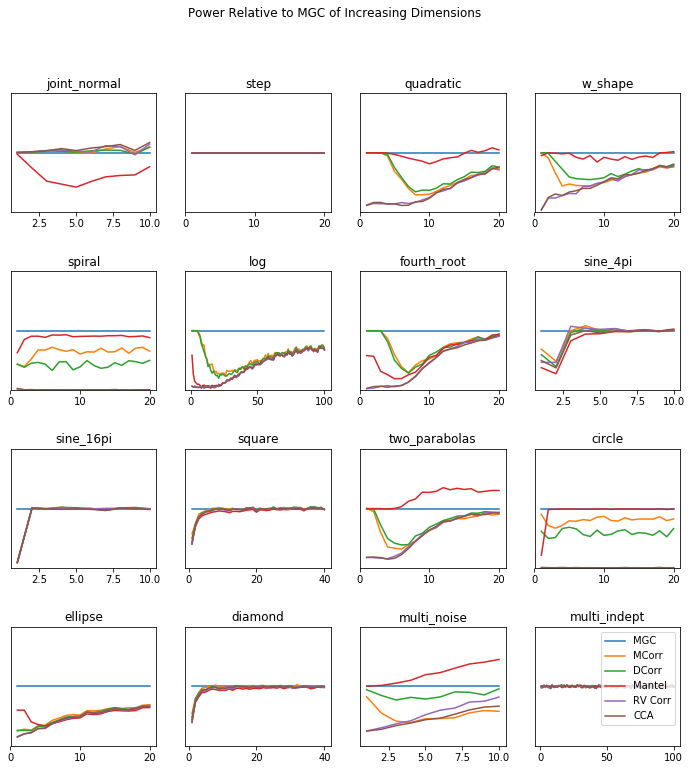

In [32]:
plot_all_curves()

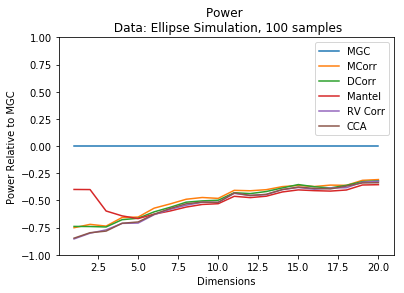

CPU times: user 135 ms, sys: 15.1 ms, total: 150 ms
Wall time: 149 ms


In [61]:
%%time
plot_power_curve(power_results, 'Ellipse')

## Results for simulations
* ones that got the correct power curve
    * quadratic, w shape, two parabolas, fourth root, joint normal, sine 16pi, independence, multiplicative (except for DCorr), log
* ones that are incorrect
    * step function, spiral, sine 4pi, circle, ellipse, diamond

## Parallel code

In [11]:
def power_vs_dimension_parallel(params_dict):
    '''
    Generate power of an independence test given a simulation for a range of dimensions
    
    :param independence_test: an independence_test object
    :param simulation_type: a simulation function from mgcpy.benchmarks.simulations
    :param dim_range: the upper end of the range of dimension
    :return: power for each dimension
    '''
    print(params_dict['sim_name'], params_dict['independence_test'].get_name())
    estimated_power = np.zeros(params_dict['dim_range'])
    for d in range(1, params_dict['dim_range']+1):
        estimated_power[d-1] = power(params_dict['independence_test'], params_dict['simulation_type'], 
                                     num_samples=100, num_dimensions=d, 
                                     simulation_type=params_dict['sim_name'])
    print('finish')
    return (params_dict, estimated_power)

In [12]:
mcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mcorr')
dcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='dcorr')

params_dict = [{'independence_test': mcorr, 'simulation_type': quad_sim, 'dim_range': 20, 'sim_name': 'quadratic'}, 
              {'independence_test': dcorr, 'simulation_type': quad_sim, 'dim_range': 20, 'sim_name': 'quadratic'}]

In [13]:
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

quadratic dcorr
quadratic mcorr
finish
finish


In [14]:
results

[({'dim_range': 20,
   'independence_test': <mgcpy.independence_tests.dcorr.DCorr at 0x1a15a836d8>,
   'sim_name': 'quadratic',
   'simulation_type': <function mgcpy.benchmarks.simulations.quad_sim>},
  array([1.   , 1.   , 1.   , 0.924, 0.682, 0.542, 0.353, 0.311, 0.233,
         0.21 , 0.19 , 0.13 , 0.152, 0.164, 0.128, 0.122, 0.104, 0.09 ,
         0.095, 0.093])),
 ({'dim_range': 20,
   'independence_test': <mgcpy.independence_tests.dcorr.DCorr at 0x1a15a835f8>,
   'sim_name': 'quadratic',
   'simulation_type': <function mgcpy.benchmarks.simulations.quad_sim>},
  array([1.   , 1.   , 1.   , 0.972, 0.8  , 0.633, 0.474, 0.392, 0.292,
         0.257, 0.226, 0.165, 0.193, 0.176, 0.161, 0.137, 0.14 , 0.115,
         0.126, 0.124]))]